<a href="https://colab.research.google.com/github/nojiyoon/gan_first/blob/main/06_%EB%8B%A8%EC%88%9C%ED%95%9C1010%ED%8C%A8%ED%84%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# import libraries

import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy

# 실제 데이터 소스

In [25]:
def generate_real():
  real_data = torch.FloatTensor([1, 0, 1, 0])
  return real_data

In [26]:
# function to generate real data

def generate_real():
  real_data = torch.FloatTensor(
      [random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2),
       random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2)]
  )
  return real_data

# 판별기 만들기

In [27]:
class Discriminator(nn.Module):

  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(4, 3),
        nn.Sigmoid(),
        nn.Linear(3, 1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.MSELoss()

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    
    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.2, marker='.', 
            grid=True, yticks=(0, 0.25, 0.5))
    pass

# 판별기 테스트하기

In [28]:
def generate_random(size):
  random_data = torch.rand(size)
  return random_data

In [29]:
D = Discriminator()

for i in range(10000):
  # 실제 데이터
  D.train(generate_real(), torch.FloatTensor([1.0]))
  # 생성된 데이터
  D.train(generate_random(4), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000


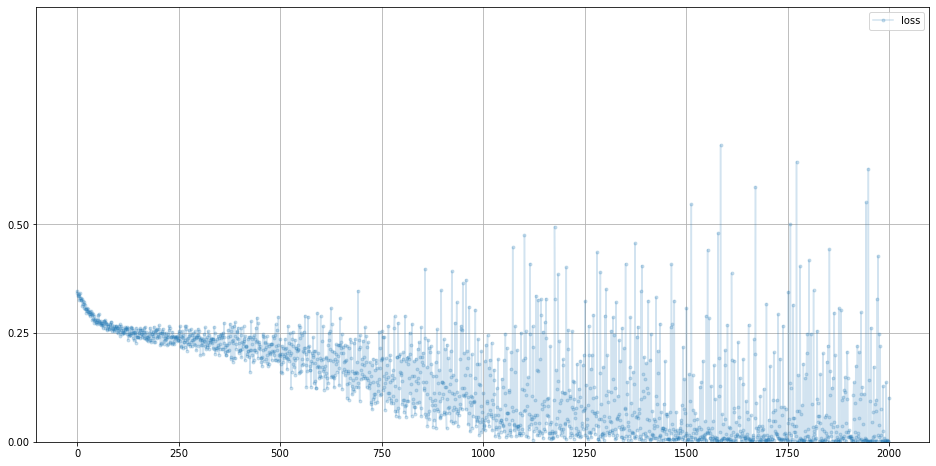

In [30]:
D.plot_progress()

In [31]:
# manually run discriminator to check it can tell real data from fake

print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.7929439544677734
0.14033834636211395


# 생성기 만들기

In [32]:
class Generator(nn.Module):

  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(1, 3),
        nn.Sigmoid(),
        nn.Linear(3, 4),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.MSELoss()

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass

  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, D, inputs, targets):
    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차 계산
    loss = D.loss_function(d_output, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.2, marker='.', 
            grid=True, yticks=(0, 0.25, 0.5))
    pass

# 생성기 결과 확인하기

In [33]:
# chek the generator output is of the right type and shape

G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.4149, 0.6545, 0.3755, 0.5643], grad_fn=<SigmoidBackward>)

# GAN 훈련하기

In [35]:
%%time

# 판별기 및 생성기 생성

D = Discriminator()

G = Generator()

# 판별기와 생성기 훈련

for i in range(10000):

  # 1단계: 참에 대해 판별기 훈련
  D.train(generate_real(), torch.FloatTensor([1.0]))

  # 2단계: 거짓에 대해 판별기 훈련
  # G의 기울기가 계산되지 않도록 detach() 함수를 이용
  D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

  # 3단계: 생성기 훈련
  G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

  pass

counter =  10000
counter =  20000
CPU times: user 11.8 s, sys: 20.3 ms, total: 11.8 s
Wall time: 11.8 s


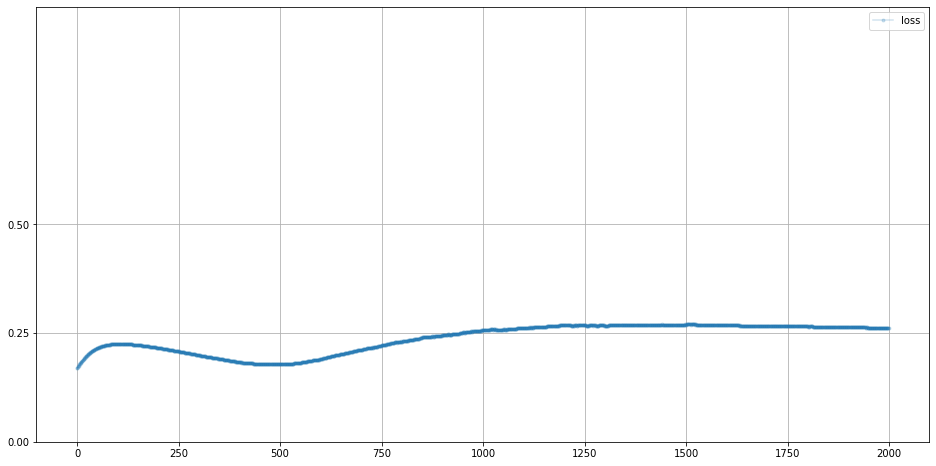

In [36]:
# plot discriminator error

D.plot_progress()

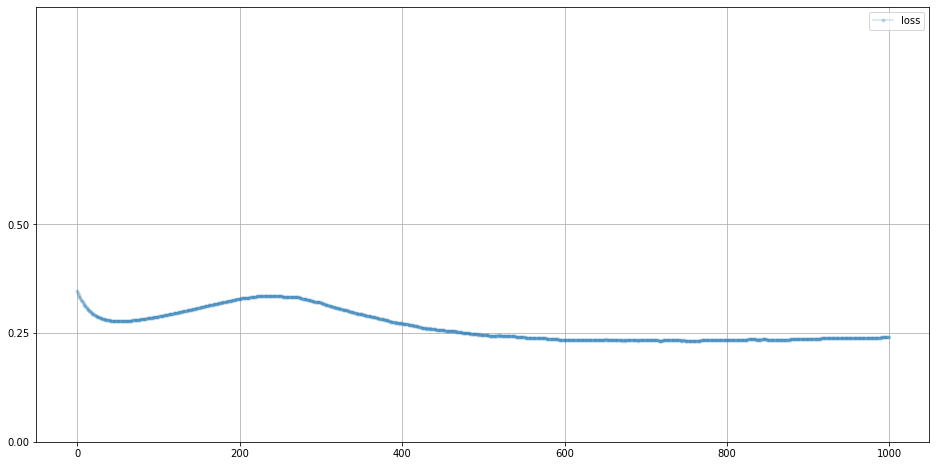

In [37]:
G.plot_progress()

In [38]:
# manually run generator to see it's outputs

G.forward(torch.FloatTensor([0.5]))

tensor([0.9552, 0.0279, 0.9220, 0.0321], grad_fn=<SigmoidBackward>)

# Train GAN

In [51]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

image_list = []

# train Discriminator and Generator

for i in range(10000):
    
    # train discriminator on true
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    # add image to list every 1000
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass

counter =  10000
counter =  20000
CPU times: user 12.1 s, sys: 25.1 ms, total: 12.1 s
Wall time: 12.1 s


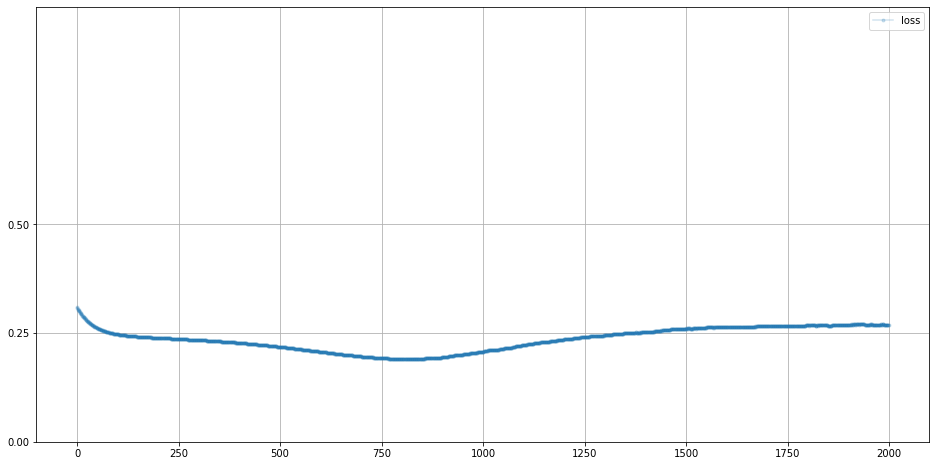

In [53]:
# plot discriminator error

D.plot_progress()

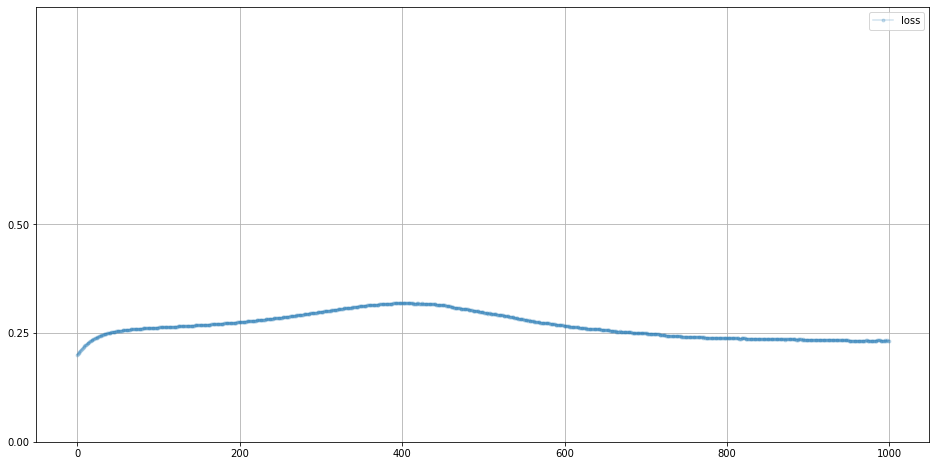

In [54]:
# plot generator error

G.plot_progress()

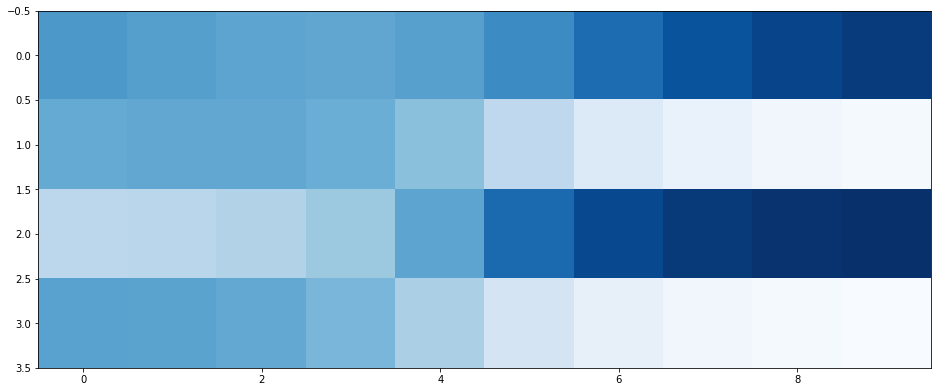

In [52]:
plt.figure(figsize = (16,8))
plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')